## LangGraph로 에이전트 시스템 만들기
다중 에이전트로 이미지가 포함된 리포트 자동화해보기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### State 설정

In [2]:
from typing import Annotated, TypedDict, List, Dict, Sequence
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# State definition
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    outline: Dict[str, str]
    current_section: int
    section_content: str
    section_image: str
    image_prompt: str
    total_sections: int
    full_report: List[Dict[str, str]]

# Graph builder initialization
graph_builder = StateGraph(State)

### 웹검색 정의
- 일단 여기서는 과거 방식 사용

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults(max_results=3)

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_39769/1418412009.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search = TavilySearchResults(max_results=3)


### 개요 작성 에이전트 설정

개요를 저장하는 data model 정의

In [4]:
from pydantic import BaseModel, Field, create_model

# 사용자로부터 입력받은 전체 섹션 수에 따라 Data model의 key와 value를 동적으로 정의
# create_model 함수는 Pydantic Data model의 이름과 key:value 값을 기반으로 동적인 Data model을 만들 수 있게 보조
def create_outline_model(section_count: int):
    fields = {f"section{i}": 
              (str, Field(description=f"Title for section {i}")) for i in range(1, section_count + 1)}
    return create_model("DynamicOutline", **fields)

테스트

In [5]:
fields = {f"section{i}": 
              (str, Field(description=f"Title for section {i}")) for i in range(1, 3 + 1)}

DynamicOutline = create_model("DynamicOutline", **fields)

for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'



In [6]:
DynamicOutline = create_outline_model(5)
for key, value in DynamicOutline.model_fields.items():
    print(f"key:{key}\n")
    print(f"value:{value}\n")

key:section1

value:annotation=str required=True description='Title for section 1'

key:section2

value:annotation=str required=True description='Title for section 2'

key:section3

value:annotation=str required=True description='Title for section 3'

key:section4

value:annotation=str required=True description='Title for section 4'

key:section5

value:annotation=str required=True description='Title for section 5'



개요 생성 에이전트

In [7]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o") 

In [8]:
def outline_generator(state: State):
    DynamicOutline = create_outline_model(state["total_sections"])
    outline_parser = JsonOutputParser(pydantic_object=DynamicOutline)

    outline_prompt = PromptTemplate(
        template="""
        Create an outline for a detailed report with exactly {section_count} main sections.
        {format_instructions}
        The topic is: {topic}
        """,
        input_variables=["section_count", "topic"],
        partial_variables={"format_instructions": outline_parser.get_format_instructions()},
    )
    
    chain = outline_prompt | llm | outline_parser
    
    outline = chain.invoke({
        "section_count": state["total_sections"], 
        "topic": state["messages"][-1].content
    })
    return {"outline": outline}

이미지 생성 에이전트

In [9]:
from openai import OpenAI
from langchain_core.tools import tool
from langchain_core.messages import AIMessage

client = OpenAI()

def generate_image(prompt):
    """Generate an image using DALL-E based on the given prompt."""
    response = client.images.generate(
        model="dall-e-3",
        prompt=prompt,
        size="1024x1024",
        quality="standard",
        n=1
    )
    return response.data[0].url

def image_generator(state: State):

    prompt_template = PromptTemplate(
        template="""
        Based on the following section content, create a prompt for generating an infographic that represents this section.
        
        Section content: 
        
        {section_content}
        
        Image generation prompt(under 500 characters):""",
        input_variables=["section_content"],
    )
    
    image_prompt = llm.invoke(prompt_template.format(section_content=state["section_content"]))
    image_url = generate_image(image_prompt.content)

    current_section = {
        "title": state['outline'][f"section{state['current_section']}"],
        "content": state['section_content'],
        "image_url": image_url,
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt
    }

    updated_full_report = state.get("full_report", []) + [current_section]

    print(f"Completed section {state['current_section']} of {state['total_sections']}")

    return {
        "image_prompt": image_prompt.content if isinstance(image_prompt, AIMessage) else image_prompt,
        "section_image": image_url,
        "current_section": state["current_section"] + 1,
        "full_report": updated_full_report
    }


컨텐트 작성 에이전트

In [10]:
def contents_writer(state: State):
    if "error" in state:
        return {"messages": [AIMessage(content=f"An error occurred: {state['error']}")]}
    
    if state["current_section"] > state["total_sections"]:
        return {"messages": [AIMessage(content="Report completed.")]}
        
    current_section_key = f"section{state['current_section']}"
    current_topic = state["outline"][current_section_key]
    search_results = search.invoke(current_topic)    
    
    previous_sections_content = []
    for i in range(1, state['current_section']):
        section_key = f"section{i}"
        if section_key in state["section_content"]:
            previous_sections_content.append(f"""
            Section {i}: 
            {state['outline'][section_key]}
            {state['section_content'][section_key]}
            """)
    
    previous_sections = "\n\n".join(previous_sections_content)
    
    section_prompt = PromptTemplate(
        template="""
        Write a detailed section for the topic: {topic}. 
        
        Use the following search results for information: {search_results}
        
        Previous sections:
        {previous_sections}
        Write only the content for this section, 
        do not include any image prompts or suggestions.
        Detailed statistics or information is needed, 
        so you should include collected information from search result.""",
        input_variables=["topic", "search_results", "previous_sections"],
    )
    section_content = llm.invoke(section_prompt.format(
        topic=current_topic,
        search_results=search_results,
        previous_sections=previous_sections
    ))

    return {
        "section_content": section_content.content,
        "current_section": state["current_section"]
    }

워드 생성 에이전트

In [11]:
from docx import Document
from docx.shared import Inches
import requests
from io import BytesIO

def report_generator(state: State):
    doc = Document()
    doc.add_heading(f"Report: {state['messages'][0].content}", 0)

    for section in state['full_report']:
        doc.add_heading(section['title'], level=1)
        doc.add_paragraph(section['content'])
        
        # 이미지 추가
        if section['image_url'] != "Image generation failed":
            try:
                response = requests.get(section['image_url'])
                image = BytesIO(response.content)
                doc.add_picture(image, width=Inches(6))
                doc.add_paragraph(f"Image prompt: {section['image_prompt']}")
            except Exception as e:
                doc.add_paragraph(f"Failed to add image: {str(e)}")

        doc.add_page_break()

    # 보고서 저장
    filename = f"report_{state['messages'][0].content}.docx".replace(" ", "_")
    doc.save(filename)

    return {
        "messages": [AIMessage(content=f"Report finalized and saved as {filename}.")],
        "report_file": filename
    }


### 그래프 구축

In [12]:
# Add nodes
graph_builder.add_node("outline_generator", outline_generator)
graph_builder.add_node("contents_writer", contents_writer)
graph_builder.add_node("image_generator", image_generator)
graph_builder.add_node("report_generator", report_generator)

# Add edges
graph_builder.add_edge(START, "outline_generator")
graph_builder.add_edge("outline_generator", "contents_writer")
graph_builder.add_edge("contents_writer", "image_generator")
graph_builder.add_edge("report_generator", END)
# Add conditional edges
def should_continue_writing(state: State):
    if state["current_section"] <= state["total_sections"]:
        return "write_section"
    else:
        return "finalize_report"

graph_builder.add_conditional_edges(
    "image_generator",
    should_continue_writing,
    {
        "write_section": "contents_writer",
        "finalize_report": "report_generator"
    }
)

# Compile graph
graph = graph_builder.compile()

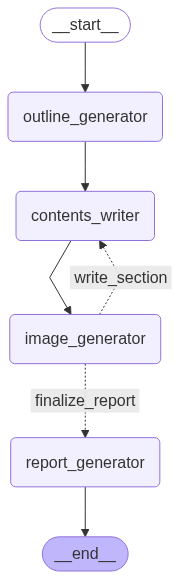

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

그래프 실행

In [14]:
import os

current_directory = os.getcwd()
print(f"현재 작업 디렉토리: {current_directory}")

현재 작업 디렉토리: /Users/sguys99/Desktop/project/langchain-study/fc-agent/part3/ch3.agent


In [15]:
from langchain_core.messages import HumanMessage

# 사용자 입력 받기
topic = input("보고서 주제를 입력하세요: ")
total_sections = int(input("생성할 섹션의 수를 입력하세요: "))

# 초기 상태 설정
initial_state = {
    "messages": [HumanMessage(content=topic)],
    "total_sections": total_sections,
    "current_section": 1,
}

# 그래프 실행
for chunk in graph.stream(initial_state,stream_mode="update"):
    print(chunk)

print("\n=== 보고서 생성 완료 ===")

Completed section 1 of 3
Completed section 2 of 3
Completed section 3 of 3

=== 보고서 생성 완료 ===
